# Predicting the Football match results

We have the data of **SERIE A** matches and the odds of winning to draw to losing for each match. We need to predict the match results from this historical data.

## Problem and To DO

* All the "Serie A" football matches of the last 8 years are provided. Your goal is to predict the final result, having at your disposal the odds of various bookmakers.

* The use of external sources is encouraged, with some recommendation. Of course, the actual results of these matches can be easily downloaded from the web. However, this competition it is intended to be for fun and learning and therefore the names of the teams are given.

* The train and the test set was splitted non randomly. Your are asked to predict the last 2 years.

## Data

>File descriptions
 
* train.csv - the training set
* test.csv - the test set
* submission_example.csv - a sample submission file in the correct format

## Evaluate

The evaluation is based on whether we can predict the results of a match given the historical data.

## Features

### Data fields
ID = An anonymous ID unique to a given match

Date = Date of the match

FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win). This is the target variable

HomeTeam = Home Team

AwayTeam = Away Team

B365H = Bet365 home win odds, B365D = Bet365 draw odds, B365A = Bet365 away win odds

BWH = Bet&Win home win odds, BWD = Bet&Win draw odds, BWA = Bet&Win away win odds

IWH = Interwetten home win odds, IWD = Interwetten draw odds, IWA = Interwetten away win odds

LBH = Ladbrokes home win odds, LBD = Ladbrokes draw odds,LBA = Ladbrokes away win odds

VCH = VC Bet home win odds, VCD = VC Bet draw odds,VCA = VC Bet away win odds

WHH = William Hill home win odds,WHD = William Hill draw odds,WHA = William Hill away win odds

# Section: Imports

Dump all imports here!!!

In [73]:
# Mand. imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Other imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

np.random.seed(42)

# Lets check out our data
We need to:
* Split data into train, valid
* Work on train

In [2]:
# Read csv
football_df = pd.read_csv("data/train.csv")
football_df = football_df.sample(frac=1).reset_index(drop=True)

# Creating feature set and label set
X = football_df.drop('FTR', axis=1)
y = football_df['FTR']

# [X.shape,y.shape]

# Splitting data to train and test data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

# Lets do some EDA now

We can check for the following things:
* We would require only the `Year` from the datetime column as the results will vary based on the year. ✔
* We can fill the missing data in the `win, draw, lose ODDS` by taking a mean from other columns where `win, draw, lose ODDS` is present
* We can convert the team name to numerical values based on the team strength over the years: (`1` being `high tier` and `20` being `low tier`)
    * To convert team name to numerical value.. First we need to find the team rank. Rank 1- highest, rank 27-lowest
    * Check team_ranking dataframe for the ranks of the teams

In [3]:
X_train.columns

Index(['ID', 'Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD',
       'WHA', 'VCH', 'VCD', 'VCA'],
      dtype='object')

## Step 1: Converting Date to only year
* 1. We would require only the Year from the datetime column as the results will vary based on the year.

In [4]:
def convert_date_to_year(df):
    """
    Fn to extract the year from the date.
    df : pandas.DataFrame
    """
    df = df.copy()
    df['Year'] = pd.to_datetime(df.Date).dt.year
    df = df.drop('Date', axis=1)
    
    return df

In [5]:
# 3. We can convert the team name to numerical values based on the team strength over the years.

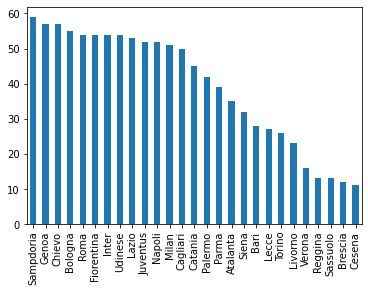

In [6]:
X_train["AwayTeam"].value_counts().plot.bar();

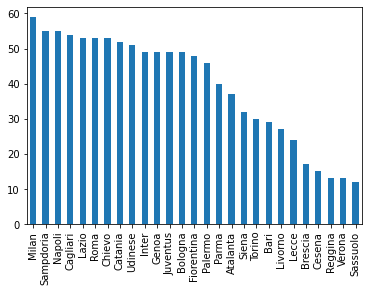

In [7]:
X_train["HomeTeam"].value_counts().plot.bar();

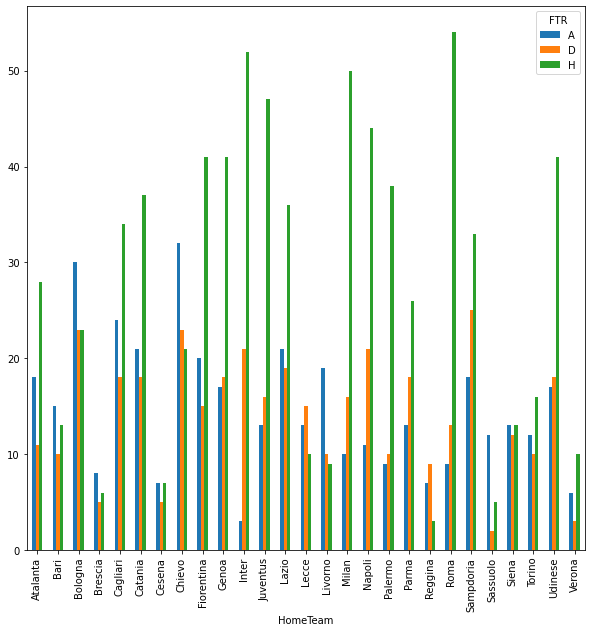

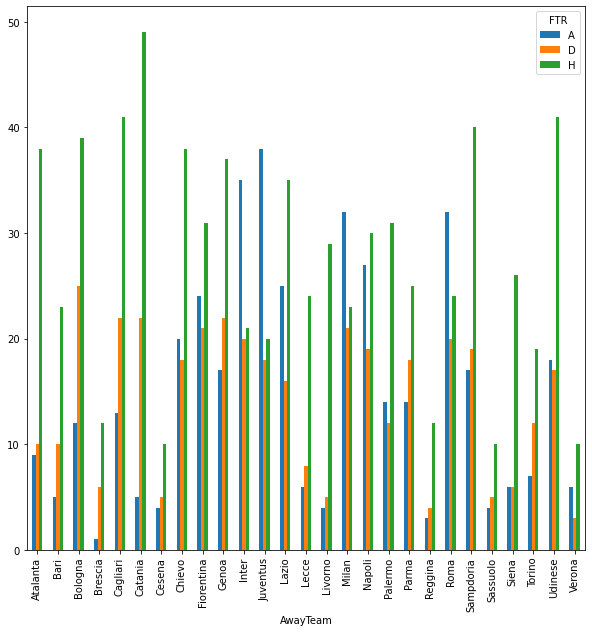

In [8]:
pd.crosstab(football_df["HomeTeam"], football_df["FTR"]).plot.bar(figsize=(10,10));
pd.crosstab(football_df["AwayTeam"], football_df["FTR"]).plot.bar(figsize=(10,10));

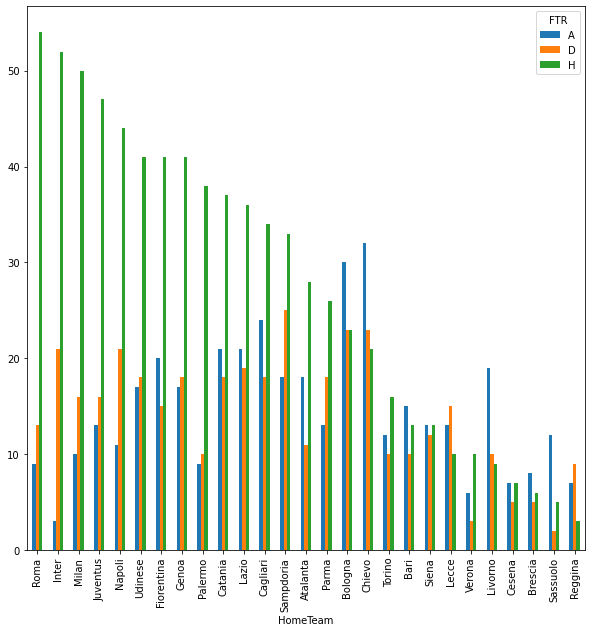

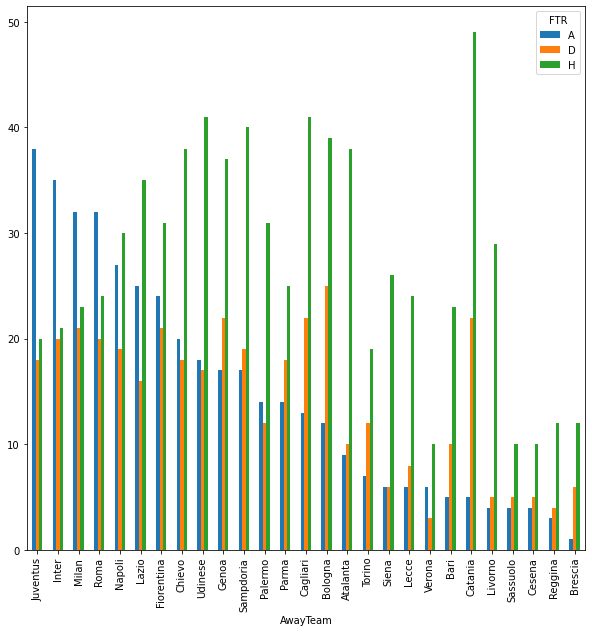

In [9]:
pd.crosstab(football_df["HomeTeam"], football_df["FTR"]).sort_values("H", ascending=False).plot.bar(figsize=(10,10));
pd.crosstab(football_df["AwayTeam"], football_df["FTR"]).sort_values("A", ascending=False).plot.bar(figsize=(10,10));

## Step 3: Label encoding (Custom)
## Now we will use the ranks as a label encoder for our dataset
* We can work with training data since we have the ranks inplace

In [155]:
# Lets get the unique clubs from our dataset
unique_teams = pd.unique(football_df["HomeTeam"])
unique_teams = np.append(unique_teams,'Empoli')
unique_teams = np.append(unique_teams,'Frosinone')
unique_teams = np.append(unique_teams,'Carpi')

In [156]:
def team_wins_draws(team):
    """
    Function to calculate the totals points based on total points based on wins+draws.
    A win is considered to be '3' points
    A draw is considered to be '1' point
    
    Parameter: 
    ==========
    team - Specify the team name
    
    Return:
    =======
    Count - Total points secured by the team
    --------------------------------------------
    """
    # Home wins count
    count=football_df[((football_df.HomeTeam)==team) & ((football_df.FTR)=="H")].HomeTeam.value_counts()
    # Away wins count
    count+=football_df[((football_df.AwayTeam)==team) & ((football_df.FTR)=="A")].AwayTeam.value_counts()
    # Total points through wins
    count*=3
    # Total draws
    count+=football_df[((football_df.HomeTeam)==team) & ((football_df.FTR)=="D")].HomeTeam.value_counts()
    count+=football_df[((football_df.AwayTeam)==team) & ((football_df.FTR)=="D")].AwayTeam.value_counts()
    return count[0]

In [157]:
def total_poss_points(team):
    """
    Function to calculate the totals possible points for a team by winning ofcourse.
    A win is considered to be 3 points.
    
    Parameter: 
    ==========
    team - Specify the team name
    
    Return:
    =======
    Count - Total points possible by the team
    ----------------------------------------------
    """
    count=football_df[football_df["HomeTeam"]==team].HomeTeam.value_counts()
    count+=count
    count*=3
    return count[0] if count.size > 0 else 0

In [158]:
# Getting the home wins, away wins, draws for each team
teamWins_dict={}
for team in unique_teams:
    poss_points = total_poss_points(team)
    if poss_points > 0:
        teamWins_dict[team] = format(team_wins_draws(team)/poss_points,".3f")
    else:
        teamWins_dict[team] = format(0,".3f")
# Refining the Dictionary
data = {"team": list(teamWins_dict.keys()),
        "teamPerc": list(teamWins_dict.values())}

In [159]:
# Now create Dataframe with the dictionary
team_Ranking = pd.DataFrame(data)
# Getting the team ranks
team_Ranking.sort_values("teamPerc", ascending=False, inplace=True)
team_Ranking.reset_index(drop=True, inplace=True)
team_Ranking["Rank"]=team_Ranking.index+1
team_Ranking

,team,teamPerc,Rank
0,Inter,0.662,1
1,Roma,0.638,2
2,Juventus,0.634,3
3,Milan,0.621,4
4,Napoli,0.555,5
5,Palermo,0.520,6
6,Fiorentina,0.507,7
7,Lazio,0.478,8
8,Verona,0.474,9
9,Genoa,0.469,10


In [160]:
def teamName_to_ranks(src_df):
    """
    Function to convert the team names to numeical values.
    
    Parameters:
    ===========
    src_df - Dataframe where the conversion is needed.
    
    Return:
    =======
    new_df - Dataframe with team names converted to numerical values.
    ----------------------------------------------------------------
    """
    src_df = src_df.copy()
    for team in unique_teams:
        # Change in HomeTeam Column
        if src_df.HomeTeam.isin([team]).any():
            src_df["HomeTeam"] = src_df["HomeTeam"].str.replace(team,
                                                        str(team_Ranking[(team_Ranking.team)==team].Rank.item()))
        # Change in AwayTeam Column
        if src_df.AwayTeam.isin([team]).any():
            src_df["AwayTeam"] = src_df["AwayTeam"].str.replace(team,
                                                        str(team_Ranking[(team_Ranking.team)==team].Rank.item()))
    # Change the dataype values from Object to int
    src_df["HomeTeam"] = src_df["HomeTeam"].astype(str).astype("int64")
    src_df["AwayTeam"] = src_df["AwayTeam"].astype(str).astype("int64")
    return src_df

## Step 2: We need to fill the missing values of match predictions
* Lets keep it simple for now and just fill with mean()
* Filling it with mean of the other sites is the only logical way to go

In [16]:
# create list of columns that are not required for Home, Away, Draw
home = ['ID', 'HomeTeam', 'AwayTeam', 'B365D', 'B365A','BWD',
        'BWA', 'IWD', 'IWA', 'LBD', 'LBA', 'WHD',
        'WHA', 'VCD', 'VCA', 'Year']
away = ['ID', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'BWH', 'BWD',
       'IWH', 'IWD', 'LBH', 'LBD', 'WHH', 'WHD',
       'VCH', 'VCD', 'Year']
draw = ['ID', 'HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'BWH',
       'BWA', 'IWH', 'IWA', 'LBH', 'LBA', 'WHH', 'WHA',
       'VCH', 'VCA', 'Year']

In [17]:
def filling_missing_matchpredictions(df):
    """
    Function to find the mean of the match predictions w.r.t the match.
    
    Parameter:
    ==========
    df - Source dataframe
    
    Returns:
    ========
    
    df - Source dataframe with mean in missing value places
    -------------------------------------------------------
    """
    df=df.copy()
    pd.options.display.float_format = '{:.2f}'.format
    tmp=df[df.isna().any(axis=1)]
    
    # filling NA values for Home
    home_mean=df[df.isna().any(axis=1)].drop(home,axis=1).apply(lambda x:x.mean(), axis=1)
    home_mean.fillna(0, inplace=True)
    home_cols =[col for col in df.columns if col not in home]
    tmp=tmp.copy()
    tmp[home_cols] = tmp[home_cols].T.fillna(home_mean).T
    
    # filling NA values for Away
    away_mean=df[df.isna().any(axis=1)].drop(away,axis=1).apply(lambda x:x.mean(), axis=1)
    away_mean.fillna(0, inplace=True)
    away_cols =[col for col in df.columns if col not in away]
    tmp=tmp.copy()
    tmp[away_cols] = tmp[away_cols].T.fillna(away_mean).T  
    
    # filling NA values for Draw
    draw_mean=df[df.isna().any(axis=1)].drop(draw,axis=1).apply(lambda x:x.mean(), axis=1)
    draw_mean.fillna(0, inplace=True)
    draw_cols =[col for col in df.columns if col not in draw]
    tmp=tmp.copy()
    tmp[draw_cols]=tmp[draw_cols].T.fillna(draw_mean).T
    
    # Copy the changes to main Dataframe
    df[df.isna().any(axis=1)]=tmp
    
    return df

In [18]:
X_train = convert_date_to_year(X_train)

In [19]:
X_train = teamName_to_ranks(X_train)

In [20]:
## Removing missing prediction values from Dataframe
X_train_final = filling_missing_matchpredictions(X_train) 

## With this we are done with Preprocessing......
### Lets start with modelling and prediction!
> The following models need to be used for testing:

    * DecisionTreeClassifier
    * LinearSVC
    * RandomForestClassifier
    * AdaBoostClassifier
    * ExtraTreesClassifier
    * KNeighborsClassifier
    * VotingClassifier
    * GradientBoostingClassifier
    
But first lets check with our trusty RandomForestClassifier!!!!    

In [21]:
# First preprocess the training dataset
X_valid = convert_date_to_year(X_valid)
X_valid = teamName_to_ranks(X_valid)
X_valid_final = filling_missing_matchpredictions(X_valid)

In [40]:
# Using RandonForestClassifier to predict
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_final,y_train)
print(f"Random Forest score -",format(rf_clf.score(X_valid_final,y_valid),".2f"))
# Lets do some Evaluation:
# With ROC, confusion matrix and classification report
y_preds = rf_clf.predict(X_valid_final)
print(confusion_matrix(y_valid, y_preds, labels=["H", "D", "A"]))
print(classification_report(y_valid,y_preds))

Random Forest score - 0.49
[[165  26  32]
 [ 65  17  29]
 [ 62  20  40]]
              precision    recall  f1-score   support

           A       0.40      0.33      0.36       122
           D       0.27      0.15      0.20       111
           H       0.57      0.74      0.64       223

    accuracy                           0.49       456
   macro avg       0.41      0.41      0.40       456
weighted avg       0.45      0.49      0.46       456



In [72]:
# Using cross-validation to increase the score --roc_auc_ovr,roc_auc_ovr_weighted
rf_clf2 = RandomForestClassifier(random_state=42)
model=np.mean(cross_val_score(rf_clf2,  X_train_final, y_train, cv=3, scoring='roc_auc_ovr_weighted'))
print(model)

0.6226005073795587


In [83]:
# Lets explore RandomForest more by tuning it..
# RandomSearchCV param distribution
n_estimators = np.arange(120,160)
max_depth = [None, 5, 6, 7, 8, 9, 10]
max_features = ["auto", "log2"]
min_samples_split = [2,4,6]
min_samples_leaf = [1,2,4]
param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf}
rf_clf3 = RandomForestClassifier(random_state=42)
rs_clf= RandomizedSearchCV(rf_clf3, param_distributions=param_grid,
                           cv=3,
                           n_iter=200,
                           scoring='roc_auc_ovr_weighted', verbose=2, n_jobs=-1)
rs_clf.fit(X_train_final, y_train)
rs_clf.best_params_



Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   42.5s finished


{'n_estimators': 126,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 5}

In [84]:
rs_clf.score(X_valid_final,y_valid)

0.6491205846786178

In [ ]:
# Random Search best params experimentation:  
{'n_estimators': 128,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 5
 'Accuracy got': 0.6495975977058562}

{'n_estimators': 157,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 6,
 'Accuracy got': 0.6487043533724595}


In [99]:
# Lets use GridSearchCV to get the best results..
n_estimators = np.arange(125,160)
max_depth = [5, 6]
max_features = ["auto", "log2"]
min_samples_split = [2]
min_samples_leaf = [1,4]
param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf}
gs_clf = GridSearchCV(rf_clf3,
                      param_grid=param_grid,
                      cv=3,
                      scoring='roc_auc_ovr_weighted', verbose=2, n_jobs=-1)
gs_clf.fit(X_train_final,y_train)

Fitting 3 folds for each of 280 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   59.0s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6], 'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 4], 'min_samples_split': [2],
                         'n_estimators': array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159])},
             scoring='roc_auc_ovr_weighted', verbose=2)

In [100]:
gs_clf.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 126}

In [101]:
gs_clf.score(X_valid_final,y_valid)

0.6491205846786178

In [102]:
grid={'n_estimators': [126],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['auto'],
 'max_depth': [5]}
clf1 = RandomForestClassifier(random_state=42)
clf = GridSearchCV(clf1, param_grid=grid,cv=3,
                    scoring='roc_auc_ovr_weighted', verbose=2, n_jobs=-1)
clf1.fit(X_train_final,y_train)
clf1.score(X_valid_final,y_valid)

0.4868421052631579

## Experimenting with other models

## Testing model on Test data

In [161]:
# import the test data
test_df = pd.read_csv("data/test.csv")
test_df.shape

(610, 22)

In [162]:
# Preprocessing Test data
test_df = convert_date_to_year(test_df)
test_df = teamName_to_ranks(test_df)
test_df_final = filling_missing_matchpredictions(test_df)
test_df_final.shape

(610, 22)

In [164]:
predictions = gs_clf.predict(test_df_final)
output = pd.DataFrame({'ID': test_df_final.ID, 'FTR': predictions})
output.to_csv('data/football_prediction_submission1.csv', index=False)

## Section : Saving the models
List of models:

   1. GridSearch Model - gs_clf

In [104]:
import pickle
#pickle.dump(gs_clf, open("model/gs_model1.pkl","wb"))